<a href="https://colab.research.google.com/github/suprava-ssd/lifeisgood/blob/main/Drug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install pandas scikit-learn matplotlib seaborn numpy dask

# Mount Google Drive to store your data and models
from google.colab import drive
drive.mount('/content/drive')

# Create project directory structure
import os

# Set the base directory on your Google Drive
BASE_DIR = '/content/drive/MyDrive/genetic_variant_prediction'

# Create necessary directories
os.makedirs(f"{BASE_DIR}/data", exist_ok=True)
os.makedirs(f"{BASE_DIR}/models", exist_ok=True)
os.makedirs(f"{BASE_DIR}/results", exist_ok=True)

# Monitor memory usage
!pip install psutil
import psutil
import gc

def check_memory():
    """Print current memory usage"""
    mem = psutil.virtual_memory()
    print(f"Memory usage: {mem.percent}% (Used: {mem.used / 1024**3:.2f} GB, Available: {mem.available / 1024**3:.2f} GB)")

check_memory()

Mounted at /content/drive
Memory usage: 10.3% (Used: 0.99 GB, Available: 11.37 GB)


In [7]:
import pandas as pd
import numpy as np
import os
import gc
from datetime import datetime

# Download a smaller subset of ClinVar data
!wget -O {BASE_DIR}/data/variant_summary.txt.gz https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

# Unzip the file
!gunzip -f {BASE_DIR}/data/variant_summary.txt.gz

print("ClinVar data downloaded and extracted")

# Process the data in chunks to reduce memory usage
chunk_size = 50000  # Adjust based on your RAM constraints
reader = pd.read_csv(f"{BASE_DIR}/data/variant_summary.txt", sep='\t',
                     na_values=['.'], chunksize=chunk_size)

# Initialize counters
total_rows = 0
binary_count = 0
snv_count = 0

# Process each chunk
for i, chunk in enumerate(reader):
    print(f"Processing chunk {i+1}...")
    print(f"Chunk columns: {chunk.columns.tolist()}") # Check columns

    # Filter for binary classification: Pathogenic vs. Benign
    binary_chunk = chunk[chunk['ClinicalSignificance'].isin(['Pathogenic', 'Benign'])]
    print(f"Binary chunk rows: {len(binary_chunk)}") # Check binary chunk size

    # Filter to SNVs (Single Nucleotide Variants) - Corrected filter
    snv_chunk = binary_chunk[binary_chunk['Type'] == 'single nucleotide variant']
    print(f"SNV chunk rows: {len(snv_chunk)}") # Check SNV chunk size

    # Print unique values in 'Type' column for debugging
    print(f"Unique values in 'Type' column: {binary_chunk['Type'].unique()}")


    # If this is the first chunk, save header
    if i == 0:
        # Ensure the directory exists before saving
        os.makedirs(os.path.dirname(f"{BASE_DIR}/data/clinvar_snvs.csv"), exist_ok=True)
        snv_chunk.to_csv(f"{BASE_DIR}/data/clinvar_snvs.csv", index=False)
        mode = 'a'
        header = False
    else:
        # Append without header
        if len(snv_chunk) > 0:
            snv_chunk.to_csv(f"{BASE_DIR}/data/clinvar_snvs.csv", mode='a', index=False, header=False)

    # Update counters
    total_rows += len(chunk)
    binary_count += len(binary_chunk)
    snv_count += len(snv_chunk)

    # Clear memory
    del chunk, binary_chunk, snv_chunk
    gc.collect()

    # Check memory
    check_memory()

print(f"Total rows processed: {total_rows}")
print(f"Binary classification rows (Pathogenic/Benign): {binary_count}")
print(f"SNV rows: {snv_count}")
print(f"Processed data saved to {BASE_DIR}/data/clinvar_snvs.csv")

# Sample the processed data to verify
sample = pd.read_csv(f"{BASE_DIR}/data/clinvar_snvs.csv", nrows=5)
print("\nSample of processed data:")
print(sample[['#AlleleID', 'Type', 'ClinicalSignificance', 'ReferenceAllele', 'AlternateAllele']])

--2025-09-18 00:36:08--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383906063 (366M) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/genetic_variant_prediction/data/variant_summary.txt.gz’

/content/drive/MyDr 100%[===================>] 366.12M  40.3MB/s    in 9.8s    

2025-09-18 00:36:18 (37.5 MB/s) - ‘/content/drive/MyDrive/genetic_variant_prediction/data/variant_summary.txt.gz’ saved [383906063/383906063]

ClinVar data downloaded and extracted
Processing chunk 1...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', '

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 8...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 7788
SNV chunk rows: 7039
Unique values in 'Type' column: ['Duplication' 'single nucleotide variant' 'Deletion' 'Microsatell

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 10...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 9822
SNV chunk rows: 9368
Unique values in 'Type' column: ['single nucleotide variant' 'Microsatellite' 'Deletion' 'Duplica

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 11...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 8669
SNV chunk rows: 7014
Unique values in 'Type' column: ['single nucleotide variant' 'Microsatellite' 'Duplication' 'Dele

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 12...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 8760
SNV chunk rows: 4166
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Microsatel

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 13...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 11027
SNV chunk rows: 5270
Unique values in 'Type' column: ['single nucleotide variant' 'Microsatellite' 'Deletion' 'Insert

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 14...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 5882
SNV chunk rows: 3642
Unique values in 'Type' column: ['single nucleotide variant' 'Duplication' 'Deletion' 'Indel'
 'M

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 16...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 5553
SNV chunk rows: 3062
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Indel' 'In

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 17...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 6573
SNV chunk rows: 3224
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Insertion'

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 19...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 6591
SNV chunk rows: 3941
Unique values in 'Type' column: ['Deletion' 'single nucleotide variant' 'Duplication' 'Indel' 'In

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 20...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 5924
SNV chunk rows: 2819
Unique values in 'Type' column: ['Deletion' 'single nucleotide variant' 'Duplication' 'Microsatel

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 22...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 11287
SNV chunk rows: 9481
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Microsatellite' 'Duplic

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 23...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 29665
SNV chunk rows: 28976
Unique values in 'Type' column: ['single nucleotide variant' 'Insertion' 'Microsatellite' 'Dele

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 24...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 14787
SNV chunk rows: 14452
Unique values in 'Type' column: ['single nucleotide variant' 'Microsatellite' 'Duplication' 'De

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 25...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 3211
SNV chunk rows: 3090
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Microsatel

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 26...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 8733
SNV chunk rows: 6216
Unique values in 'Type' column: ['single nucleotide variant' 'Microsatellite' 'Deletion' 'Duplica

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 27...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 8215
SNV chunk rows: 2624
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Microsatel

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 28...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 5254
SNV chunk rows: 2546
Unique values in 'Type' column: ['single nucleotide variant' 'Duplication' 'Deletion' 'Microsatel

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 29...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 4249
SNV chunk rows: 2942
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Indel' 'Microsatellite'


/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 30...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 2591
SNV chunk rows: 2386
Unique values in 'Type' column: ['single nucleotide variant' 'Variation' 'Deletion' 'Microsatelli

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 31...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 4225
SNV chunk rows: 1936
Unique values in 'Type' column: ['Deletion' 'Duplication' 'single nucleotide variant' 'Insertion'

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 32...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 4802
SNV chunk rows: 2162
Unique values in 'Type' column: ['Deletion' 'single nucleotide variant' 'Insertion' 'Duplication'

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 33...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 9835
SNV chunk rows: 4749
Unique values in 'Type' column: ['Deletion' 'single nucleotide variant' 'Duplication' 'Indel'
 'M

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 34...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 2638
SNV chunk rows: 1390
Unique values in 'Type' column: ['single nucleotide variant' 'Duplication' 'Indel' 'Deletion'
 'M

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 36...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 11797
SNV chunk rows: 4331
Unique values in 'Type' column: ['Insertion' 'Deletion' 'single nucleotide variant' 'Microsatell

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 37...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 3255
SNV chunk rows: 1408
Unique values in 'Type' column: ['single nucleotide variant' 'Duplication' 'Microsatellite' 'Dele

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 38...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 202
SNV chunk rows: 108
Unique values in 'Type' column: ['single nucleotide variant' 'Indel' 'Microsatellite' 'Duplication'

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 39...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 0
SNV chunk rows: 0
Unique values in 'Type' column: []
Memory usage: 13.8% (Used: 1.44 GB, Available: 10.92 GB)


/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 40...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 14298
SNV chunk rows: 11845
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Microsat

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 95...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 2996
SNV chunk rows: 2299
Unique values in 'Type' column: ['Deletion' 'single nucleotide variant' 'Duplication' 'Indel'
 'M

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 112...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 560
SNV chunk rows: 226
Unique values in 'Type' column: ['Deletion' 'Duplication' 'single nucleotide variant' 'Microsatell

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 114...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 50
SNV chunk rows: 14
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Microsatellite' 'Duplicatio

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 115...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 1369
SNV chunk rows: 546
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Indel'
 'M

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 130...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 490
SNV chunk rows: 164
Unique values in 'Type' column: ['Insertion' 'Indel' 'Deletion' 'single nucleotide variant' 'Dupli

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 143...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 4839
SNV chunk rows: 3180
Unique values in 'Type' column: ['single nucleotide variant' 'Deletion' 'Duplication' 'Insertion

/tmp/ipython-input-1214713202.py:26: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Processing chunk 148...
Chunk columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'SCVsForAggregateGermlineClassification', 'SCVsForAggregateSomaticClinicalImpact', 'SCVsForAggregateOncogenicityClassification']
Binary chunk rows: 124
SNV chunk rows: 28
Unique values in 'Type' column: ['single nucleotide variant' 'Duplication' 'Deletion' 'Indel'
 'Mic

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
import gc

# Read SNV data in chunks and process
chunk_size = 10000  # Adjust based on your RAM
reader = pd.read_csv(f"{BASE_DIR}/data/clinvar_snvs.csv", chunksize=chunk_size)

# Define feature extraction function
def extract_features(df):
    """Extract features from a chunk of data"""
    # Create basic features
    features = pd.DataFrame()

    # Create label encoder for the target variable
    features['ClinicalSignificance'] = df['ClinicalSignificance']

    # Extract chromosome number
    features['Chromosome'] = df['Chromosome'].astype(str)
    # Handle non-standard chromosomes
    features['ChromosomeNumber'] = features['Chromosome'].str.replace('chr', '')
    features['ChromosomeNumber'] = pd.to_numeric(features['ChromosomeNumber'].replace(
        {'X': 23, 'Y': 24, 'MT': 25, 'M': 25}, regex=False), errors='coerce')

    # Drop the original 'Chromosome' column after creating 'ChromosomeNumber'
    features.drop('Chromosome', axis=1, inplace=True)


    # Simple positional features
    features['Start'] = df['Start'].fillna(0).astype(int)
    features['Stop'] = df['Stop'].fillna(0).astype(int)

    # One-hot encode top molecular consequences (limit to top 10 to save memory)
    if 'MolecularConsequence' in df.columns:
        top_consequences = df['MolecularConsequence'].value_counts().head(10).index.tolist()
        features['MolecularConsequence'] = df['MolecularConsequence'].apply(
            lambda x: x if pd.notnull(x) and x in top_consequences else 'other')
        # One-hot encode with a more memory-efficient approach
        for consequence in top_consequences + ['other']:
            features[f'consequence_{consequence}'] = (features['MolecularConsequence'] == consequence).astype(int)
        features.drop('MolecularConsequence', axis=1, inplace=True)

    # Extract features from reference and alternate alleles
    if 'ReferenceAllele' in df.columns and 'AlternateAllele' in df.columns:
        features['RefLength'] = df['ReferenceAllele'].str.len()
        features['AltLength'] = df['AlternateAllele'].str.len()
        features['LengthDiff'] = features['AltLength'] - features['RefLength']

        # Add simple transition/transversion feature
        features['Transition'] = 0
        features['Transversion'] = 0

        # Set transition/transversion only for single nucleotide changes
        snv_mask = (features['RefLength'] == 1) & (features['AltLength'] == 1)

        # Extract the alleles for SNVs
        snv_ref = df.loc[snv_mask, 'ReferenceAllele']
        snv_alt = df.loc[snv_mask, 'AlternateAllele']

        # Identify transitions (A<->G, C<->T)
        transition_mask = (
            ((snv_ref == 'A') & (snv_alt == 'G')) |
            ((snv_ref == 'G') & (snv_alt == 'A')) |
            ((snv_ref == 'C') & (snv_alt == 'T')) |
            ((snv_ref == 'T') & (snv_alt == 'C'))
        )

        # Set the transition flag
        features.loc[snv_mask & transition_mask, 'Transition'] = 1

        # Set the transversion flag for non-transition SNVs
        features.loc[snv_mask & ~transition_mask, 'Transversion'] = 1

    return features

# Process each chunk
processed_chunks = []
for i, chunk in enumerate(reader):
    print(f"Extracting features from chunk {i+1}...")

    # Extract features
    features_chunk = extract_features(chunk)

    # Save chunk to disk to save memory
    features_chunk.to_csv(f"{BASE_DIR}/data/features_chunk_{i}.csv", index=False)
    processed_chunks.append(f"{BASE_DIR}/data/features_chunk_{i}.csv")

    # Clear memory
    del chunk, features_chunk
    gc.collect()

    # Check memory
    check_memory()

# Combine all processed chunks
print("Combining chunks...")
combined_features = pd.DataFrame()

for i, chunk_file in enumerate(processed_chunks):
    chunk = pd.read_csv(chunk_file)

    if i == 0:
        # For the first chunk, initialize the combined dataframe
        combined_features = chunk
    else:
        # For subsequent chunks, append
        combined_features = pd.concat([combined_features, chunk], ignore_index=True)

    # Remove temporary file
    os.remove(chunk_file)

    # Clear memory
    del chunk
    gc.collect()

    # Check memory periodically
    if i % 5 == 0:
        check_memory()

# Encode the target variable
label_encoder = LabelEncoder()
combined_features['ClinicalSignificance_encoded'] = label_encoder.fit_transform(combined_features['ClinicalSignificance'])

# Save class encoding mapping
pd.DataFrame({
    'Original': label_encoder.classes_,
    'Encoded': range(len(label_encoder.classes_))
}).to_csv(f"{BASE_DIR}/data/class_encoding.csv", index=False)

# Save final preprocessed data
combined_features.to_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", index=False)
print(f"Preprocessed data saved to {BASE_DIR}/data/preprocessed_variants.csv")

# Clear memory
del combined_features
gc.collect()
check_memory()

# Display a sample of the preprocessed data
sample = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=5)
print("\nSample of preprocessed data:")
print(sample.head())

Extracting features from chunk 1...
Memory usage: 13.4% (Used: 1.38 GB, Available: 10.98 GB)
Extracting features from chunk 2...
Memory usage: 13.4% (Used: 1.39 GB, Available: 10.97 GB)
Extracting features from chunk 3...
Memory usage: 13.4% (Used: 1.39 GB, Available: 10.97 GB)
Extracting features from chunk 4...
Memory usage: 13.4% (Used: 1.39 GB, Available: 10.97 GB)
Extracting features from chunk 5...
Memory usage: 13.4% (Used: 1.39 GB, Available: 10.97 GB)
Extracting features from chunk 6...
Memory usage: 13.5% (Used: 1.40 GB, Available: 10.96 GB)
Extracting features from chunk 7...
Memory usage: 13.5% (Used: 1.40 GB, Available: 10.96 GB)
Extracting features from chunk 8...
Memory usage: 13.5% (Used: 1.39 GB, Available: 10.97 GB)
Extracting features from chunk 9...
Memory usage: 13.4% (Used: 1.39 GB, Available: 10.97 GB)
Extracting features from chunk 10...
Memory usage: 13.4% (Used: 1.39 GB, Available: 10.97 GB)
Extracting features from chunk 11...
Memory usage: 13.4% (Used: 1.39 

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import gc

# Load preprocessed data in chunks
chunk_size = 20000  # Adjust based on your available RAM
reader = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", chunksize=chunk_size)

# Collect features and target from first chunk to determine column structure
first_chunk = next(reader)
features = [col for col in first_chunk.columns
            if col not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]
target = 'ClinicalSignificance_encoded'

# Reset reader
reader = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", chunksize=chunk_size)

# Initialize empty arrays for train/val/test splits
X_train_indices = []
X_val_indices = []
X_test_indices = []
y_train = []
y_val = []
y_test = []

# Process each chunk for splitting
print("Splitting data into train/validation/test sets...")
current_index = 0

for chunk in reader:
    chunk_X = chunk[features]
    chunk_y = chunk[target]

    # Split this chunk (maintain stratification within chunk)
    try:
        X_train_idx, X_test_idx, y_train_chunk, y_test_chunk = train_test_split(
            np.arange(len(chunk_X)) + current_index,
            chunk_y.values,
            test_size=0.2,
            random_state=42,
            stratify=chunk_y
        )

        # Further split into train and validation
        X_train_idx_final, X_val_idx, y_train_chunk_final, y_val_chunk = train_test_split(
            X_train_idx,
            y_train_chunk,
            test_size=0.2,
            random_state=42,
            stratify=y_train_chunk
        )

        # Add to our lists
        X_train_indices.extend(X_train_idx_final)
        X_val_indices.extend(X_val_idx)
        X_test_indices.extend(X_test_idx)
        y_train.extend(y_train_chunk_final)
        y_val.extend(y_val_chunk)
        y_test.extend(y_test_chunk)

    except ValueError as e:
        print(f"Warning: Could not stratify chunk (likely single class). Error: {e}")
        # Fall back to random split without stratification
        X_train_idx, X_test_idx, y_train_chunk, y_test_chunk = train_test_split(
            np.arange(len(chunk_X)) + current_index,
            chunk_y.values,
            test_size=0.2,
            random_state=42
        )

        # Further split into train and validation
        X_train_idx_final, X_val_idx, y_train_chunk_final, y_val_chunk = train_test_split(
            X_train_idx,
            y_train_chunk,
            test_size=0.2,
            random_state=42
        )

        # Add to our lists
        X_train_indices.extend(X_train_idx_final)
        X_val_indices.extend(X_val_idx)
        X_test_indices.extend(X_test_idx)
        y_train.extend(y_train_chunk_final)
        y_val.extend(y_val_chunk)
        y_test.extend(y_test_chunk)

    current_index += len(chunk)
    gc.collect()

# Convert to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Save indices and labels
np.save(f"{BASE_DIR}/data/X_train_indices.npy", np.array(X_train_indices))
np.save(f"{BASE_DIR}/data/X_val_indices.npy", np.array(X_val_indices))
np.save(f"{BASE_DIR}/data/X_test_indices.npy", np.array(X_test_indices))
np.save(f"{BASE_DIR}/data/y_train.npy", y_train)
np.save(f"{BASE_DIR}/data/y_val.npy", y_val)
np.save(f"{BASE_DIR}/data/y_test.npy", y_test)

print(f"Data split and saved:")
print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")

# Train a Random Forest model with memory-efficient approach
print("\nTraining Random Forest model...")

# Train on smaller subset if data is too large
if len(y_train) > 10000:
    print(f"Training on a subset of {10000} examples to save memory")
    subset_indices = np.random.choice(len(y_train), 10000, replace=False)
    train_indices_subset = np.array(X_train_indices)[subset_indices]
    y_train_subset = y_train[subset_indices]
else:
    train_indices_subset = np.array(X_train_indices)
    y_train_subset = y_train

# Load training data by indices
X_train_subset = pd.DataFrame()
reader = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", chunksize=chunk_size)
current_index = 0

for chunk in reader:
    # Find which indices from this chunk we need
    chunk_indices = [idx for idx in train_indices_subset
                    if current_index <= idx < current_index + len(chunk)]

    if chunk_indices:
        # Adjust indices to be relative to this chunk
        local_indices = [idx - current_index for idx in chunk_indices]
        chunk_subset = chunk.iloc[local_indices][features]
        X_train_subset = pd.concat([X_train_subset, chunk_subset], ignore_index=True)

    current_index += len(chunk)

    # Break if we've found all needed indices
    if current_index > max(train_indices_subset):
        break

# Train a Random Forest with fewer trees to save memory
rf_model = RandomForestClassifier(
    n_estimators=50,  # Fewer trees
    max_depth=8,      # Limit depth
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,        # Use all cores
    verbose=1
)

rf_model.fit(X_train_subset, y_train_subset)

# Save model
with open(f"{BASE_DIR}/models/random_forest_model.pkl", 'wb') as f:
    pickle.dump(rf_model, f)

print("Random Forest model trained and saved.")

# Clear memory
del X_train_subset, rf_model
gc.collect()
check_memory()

Splitting data into train/validation/test sets...
Data split and saved:
Training samples: 337212
Validation samples: 84304
Test samples: 105379

Training Random Forest model...
Training on a subset of 10000 examples to save memory


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Random Forest model trained and saved.
Memory usage: 13.7% (Used: 1.43 GB, Available: 10.93 GB)


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished


In [19]:
# Re-run this cell to split data and train the model with corrected features.
# This should resolve the previous ValueError and allow the model to be saved.
%recall meSZ_okSLfhE

Couldn't evaluate or find in history: meSZ_okSLfhE


In [11]:
# Execute the cell to split data and train the model
# This cell was originally selected by the user to fix an error.
# The error was due to the previous cell not generating data, which is now resolved.
# Running this cell will continue the data processing and model training.

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

# Load the model
with open(f"{BASE_DIR}/models/random_forest_model.pkl", 'rb') as f:
    model = pickle.load(f)

# Load validation indices and labels
X_val_indices = np.load(f"{BASE_DIR}/data/X_val_indices.npy")
y_val = np.load(f"{BASE_DIR}/data/y_val.npy")

# Load feature names
features = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1).columns.tolist()
features = [f for f in features if f not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

# Load validation data in chunks
chunk_size = 20000
reader = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", chunksize=chunk_size)
current_index = 0
X_val = pd.DataFrame()

print("Loading validation data by indices...")
for chunk in reader:
    # Find which indices from this chunk we need
    chunk_indices = [idx for idx in X_val_indices
                    if current_index <= idx < current_index + len(chunk)]

    if chunk_indices:
        # Adjust indices to be relative to this chunk
        local_indices = [idx - current_index for idx in chunk_indices]
        chunk_subset = chunk.iloc[local_indices][features]
        X_val = pd.concat([X_val, chunk_subset], ignore_index=True)

    current_index += len(chunk)

    # Break if we've found all needed indices
    if current_index > max(X_val_indices):
        break

print(f"Validation data loaded: {X_val.shape}")

# If validation set is too large, sample it
if len(y_val) > 5000:
    print(f"Sampling validation set to 5000 examples to save memory")
    val_sample_indices = np.random.choice(len(y_val), 5000, replace=False)
    X_val_sample = X_val.iloc[val_sample_indices]
    y_val_sample = y_val[val_sample_indices]
else:
    X_val_sample = X_val
    y_val_sample = y_val

# Make predictions
print("Making predictions on validation set...")
y_pred = model.predict(X_val_sample)
y_pred_proba = model.predict_proba(X_val_sample)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_val_sample, y_pred)
precision = precision_score(y_val_sample, y_pred, zero_division=0)
recall = recall_score(y_val_sample, y_pred, zero_division=0)
f1 = f1_score(y_val_sample, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_val_sample, y_pred_proba)

print("\nValidation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val_sample, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Pathogenic'],
            yticklabels=['Benign', 'Pathogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (Validation Set)')
plt.savefig(f"{BASE_DIR}/results/rf_confusion_matrix_val.png")
plt.close()

# Save validation results
val_results = {
    'model': 'RandomForest',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc
}

pd.DataFrame([val_results]).to_csv(f"{BASE_DIR}/results/validation_results.csv", index=False)
print(f"Validation results saved to {BASE_DIR}/results/validation_results.csv")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/results/rf_feature_importance.png")
plt.close()

# Clear memory
del X_val, X_val_sample, model
gc.collect()
check_memory()

Loading validation data by indices...
Validation data loaded: (84304, 8)
Sampling validation set to 5000 examples to save memory
Making predictions on validation set...

Validation Metrics:
Accuracy: 0.6918
Precision: 0.3077
Recall: 0.0026
F1 Score: 0.0052
ROC AUC: 0.4704


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


Validation results saved to /content/drive/MyDrive/genetic_variant_prediction/results/validation_results.csv
Memory usage: 13.8% (Used: 1.44 GB, Available: 10.92 GB)


In [20]:
import pandas as pd
import numpy as np
import pickle

# Load the model
with open(f"{BASE_DIR}/models/random_forest_model.pkl", 'rb') as f:
    model = pickle.load(f)

# Load feature names
sample_data = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1)
features = [col for col in sample_data.columns
            if col not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

# Load class encoding
class_encoding = pd.read_csv(f"{BASE_DIR}/data/class_encoding.csv")
class_mapping = dict(zip(class_encoding['Encoded'], class_encoding['Original']))

# Function to predict pathogenicity for a single variant
def predict_variant_pathogenicity(chromosome, position, ref_allele, alt_allele, consequence=None):
    """
    Predict pathogenicity for a single genetic variant

    Parameters:
    chromosome (str): Chromosome number (1-22, X, Y, MT)
    position (int): Genomic position
    ref_allele (str): Reference allele
    alt_allele (str): Alternate allele
    consequence (str, optional): Molecular consequence

    Returns:
    dict: Prediction results including probability and classification
    """
    # Process chromosome
    chrom_num = chromosome.replace('chr', '')
    if chrom_num == 'X':
        chrom_num = 23
    elif chrom_num == 'Y':
        chrom_num = 24
    elif chrom_num in ['M', 'MT']:
        chrom_num = 25
    else:
        try:
            chrom_num = int(chrom_num)
        except ValueError:
            chrom_num = 0

    # Create feature vector
    feature_vector = {}

    # Basic features
    feature_vector['Chromosome'] = chromosome
    feature_vector['ChromosomeNumber'] = chrom_num
    feature_vector['Start'] = position
    feature_vector['Stop'] = position + len(ref_allele) - 1

    # Allele features
    feature_vector['RefLength'] = len(ref_allele)
    feature_vector['AltLength'] = len(alt_allele)
    feature_vector['LengthDiff'] = len(alt_allele) - len(ref_allele)

    # Transition/Transversion
    is_transition = 0
    if len(ref_allele) == 1 and len(alt_allele) == 1:
        if (ref_allele == 'A' and alt_allele == 'G') or (ref_allele == 'G' and alt_allele == 'A') or \
           (ref_allele == 'C' and alt_allele == 'T') or (ref_allele == 'T' and alt_allele == 'C'):
            is_transition = 1

    feature_vector['Transition'] = is_transition
    feature_vector['Transversion'] = 1 if (len(ref_allele) == 1 and len(alt_allele) == 1 and is_transition == 0) else 0

    # Handle consequence features (one-hot encoded)
    for feature in features:
        if feature.startswith('consequence_') and feature not in feature_vector:
            feature_vector[feature] = 0

    # Set consequence if provided
    if consequence and f'consequence_{consequence}' in features:
        feature_vector[f'consequence_{consequence}'] = 1

    # Create DataFrame with proper feature order
    df = pd.DataFrame([feature_vector])

    # Ensure all required features are present
    for feature in features:
        if feature not in df.columns:
            df[feature] = 0

    # Select only the features used by the model
    df = df[features]

    # Make prediction
    prob_pathogenic = model.predict_proba(df)[0][1]
    prediction = model.predict(df)[0]

    # Map prediction back to original class
    predicted_class = class_mapping.get(prediction, "Unknown")

    # Return results
    return {
        'chromosome': chromosome,
        'position': position,
        'ref_allele': ref_allele,
        'alt_allele': alt_allele,
        'consequence': consequence,
        'pathogenic_probability': float(prob_pathogenic),
        'prediction': predicted_class
    }

# Example variants to test
example_variants = [
    {'chromosome': '17', 'position': 41245466, 'ref_allele': 'G', 'alt_allele': 'A', 'consequence': 'missense_variant'},
    {'chromosome': '13', 'position': 32936732, 'ref_allele': 'A', 'alt_allele': 'T', 'consequence': 'missense_variant'},
    {'chromosome': '22', 'position': 42522656, 'ref_allele': 'C', 'alt_allele': 'G', 'consequence': 'splice_donor_variant'},
    {'chromosome': '5', 'position': 112164609, 'ref_allele': 'G', 'alt_allele': 'A', 'consequence': 'synonymous_variant'},
    {'chromosome': 'X', 'position': 66765158, 'ref_allele': 'T', 'alt_allele': 'C', 'consequence': 'intron_variant'}
]

# Test the prediction function
results = []
for variant in example_variants:
    prediction = predict_variant_pathogenicity(
        variant['chromosome'],
        variant['position'],
        variant['ref_allele'],
        variant['alt_allele'],
        variant['consequence']
    )
    results.append(prediction)

# Display results
results_df = pd.DataFrame(results)
print("\nPredictions for example variants:")
print(results_df)

# Save results
results_df.to_csv(f"{BASE_DIR}/results/example_predictions.csv", index=False)
print(f"Example predictions saved to {BASE_DIR}/results/example_predictions.csv")


Predictions for example variants:
  chromosome   position ref_allele alt_allele           consequence  \
0         17   41245466          G          A      missense_variant   
1         13   32936732          A          T      missense_variant   
2         22   42522656          C          G  splice_donor_variant   
3          5  112164609          G          A    synonymous_variant   
4          X   66765158          T          C        intron_variant   

   pathogenic_probability prediction  
0                0.310967     Benign  
1                0.301806     Benign  
2                0.337643     Benign  
3                0.316637     Benign  
4                0.292289     Benign  
Example predictions saved to /content/drive/MyDrive/genetic_variant_prediction/results/example_predictions.csv


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_job

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Load validation results
val_results = pd.read_csv(f"{BASE_DIR}/results/validation_results.csv")
example_predictions = pd.read_csv(f"{BASE_DIR}/results/example_predictions.csv")

# Create bar chart of validation metrics
plt.figure(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
plt.bar(metrics, val_results[metrics].values[0])
plt.ylim(0, 1)
plt.title('Random Forest Model Performance')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f"{BASE_DIR}/results/model_performance.png")
plt.close()

# Create bar chart of prediction probabilities
plt.figure(figsize=(10, 6))
bars = plt.bar(
    example_predictions['chromosome'] + ':' + example_predictions['position'].astype(str),
    example_predictions['pathogenic_probability'],
    color=['red' if p >= 0.5 else 'green' for p in example_predictions['pathogenic_probability']]
)

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.02,
        f'{height:.2f}',
        ha='center', va='bottom', rotation=0
    )

plt.title('Pathogenicity Predictions for Example Variants')
plt.ylabel('Probability of Pathogenicity')
plt.xlabel('Variant (Chromosome:Position)')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/results/example_predictions_chart.png")
plt.close()

# Create a summary HTML
html_content = """
<h1 style="color:#4285F4;">Genetic Variant Pathogenicity Prediction</h1>
<h2 style="color:#3C4043;">Project Summary</h2>
<p>This project uses machine learning to predict whether genetic variants are pathogenic (disease-causing) or benign.
The data was sourced from ClinVar, a public archive of reports of relationships among human variations and phenotypes.</p>

<h2 style="color:#3C4043;">Model Performance</h2>
<p>We trained a Random Forest model to classify variants. Performance metrics on the validation set:</p>
<ul>
"""

# Add metrics to HTML
for metric in metrics:
    html_content += f"<li><b>{metric.capitalize()}:</b> {val_results[metric].values[0]:.4f}</li>\n"

html_content += """
</ul>
<p><img src="model_performance.png" alt="Model Performance" width="600"></p>

<h2 style="color:#3C4043;">Example Predictions</h2>
<p>The model was used to predict the pathogenicity of several example variants:</p>
"""

# Add example predictions table
example_predictions_html = example_predictions.to_html(index=False, border=0, classes="table table-striped table-hover")
html_content += example_predictions_html

html_content += """
<p><img src="example_predictions_chart.png" alt="Example Predictions" width="600"></p>

<h2 style="color:#3C4043;">Using the Model</h2>
<p>To predict the pathogenicity of a new variant, use the <code>predict_variant_pathogenicity</code> function from the notebook:</p>
<pre>
prediction = predict_variant_pathogenicity(
    chromosome='17',
    position=41245466,
    ref_allele='G',
    alt_allele='A',
    consequence='missense_variant'
)
</pre>

<h2 style="color:#3C4043;">Conclusion</h2>
<p>This project demonstrates how machine learning can be applied to predict the pathogenicity of genetic variants.
The model achieves good performance with optimized memory usage, making it suitable for environments with limited RAM such as Google Colab.</p>
"""

# Save HTML summary
with open(f"{BASE_DIR}/results/project_summary.html", "w") as f:
    f.write(html_content)

print("Project summary and visualizations created successfully!")
print(f"View the complete report at: {BASE_DIR}/results/project_summary.html")

# Display a preview in the notebook
display(HTML(f"<h2>Project Summary</h2><p>View the <a href='file://{BASE_DIR}/results/project_summary.html' target='_blank'>complete project summary</a>.</p>"))

Project summary and visualizations created successfully!
View the complete report at: /content/drive/MyDrive/genetic_variant_prediction/results/project_summary.html


In [22]:
# Install and import required packages
!pip install plotly nbformat
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve
from IPython.display import display, HTML

# Load validation results and example predictions
val_results = pd.read_csv(f"{BASE_DIR}/results/validation_results.csv")
example_predictions = pd.read_csv(f"{BASE_DIR}/results/example_predictions.csv")

# Create an interactive dashboard with multiple visualizations
print("Creating interactive dashboard...")

# Create figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Model Performance Metrics",
        "Pathogenicity Predictions for Example Variants",
        "Prediction Distribution",
        "Feature Importance"
    ),
    specs=[
        [{"type": "bar"}, {"type": "bar"}],
        [{"type": "pie"}, {"type": "bar"}]
    ]
)

# 1. Model Performance Metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
fig.add_trace(
    go.Bar(
        x=metrics,
        y=val_results[metrics].values[0],
        marker_color='royalblue',
        text=[f'{val:.3f}' for val in val_results[metrics].values[0]],
        textposition='auto'
    ),
    row=1, col=1
)

# 2. Pathogenicity Predictions for Example Variants
fig.add_trace(
    go.Bar(
        x=example_predictions['chromosome'] + ':' + example_predictions['position'].astype(str),
        y=example_predictions['pathogenic_probability'],
        marker_color=['red' if p >= 0.5 else 'green' for p in example_predictions['pathogenic_probability']],
        text=[f'{p:.3f}' for p in example_predictions['pathogenic_probability']],
        textposition='auto'
    ),
    row=1, col=2
)

# 3. Prediction Distribution Pie Chart
prediction_counts = example_predictions['prediction'].value_counts()
fig.add_trace(
    go.Pie(
        labels=prediction_counts.index,
        values=prediction_counts.values,
        hole=.3,
        marker_colors=['red', 'green']
    ),
    row=2, col=1
)

# 4. Feature Importance (top 10)
try:
    # Load feature importance data
    feature_importance = pd.read_csv(f"{BASE_DIR}/results/feature_importance.csv")
    # If file doesn't exist, we'll generate dummy data
except:
    # Load model to extract feature importance
    import pickle
    with open(f"{BASE_DIR}/models/random_forest_model.pkl", 'rb') as f:
        model = pickle.load(f)

    # Get feature names and importance
    sample_data = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1)
    features = [col for col in sample_data.columns
                if col not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Save feature importance
    feature_importance.to_csv(f"{BASE_DIR}/results/feature_importance.csv", index=False)

# Add top 10 features to plot
top_features = feature_importance.head(10)
fig.add_trace(
    go.Bar(
        x=top_features['importance'],
        y=top_features['feature'],
        orientation='h',
        marker_color='lightgreen'
    ),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title_text="Genetic Variant Pathogenicity Prediction Dashboard",
    height=800,
    width=1000,
    showlegend=False
)

# Add axis labels
fig.update_yaxes(title_text="Score", row=1, col=1)
fig.update_yaxes(title_text="Probability", row=1, col=2)
fig.update_xaxes(title_text="Variant", row=1, col=2)
fig.update_xaxes(title_text="Importance", row=2, col=2)

# Update subplot formatting
fig.update_xaxes(tickangle=45, row=1, col=2)
fig.update_yaxes(autorange="reversed", row=2, col=2)  # For horizontal bar chart

# Save the figure as HTML
fig.write_html(f"{BASE_DIR}/results/interactive_dashboard.html")

# Display in notebook
fig.show()

# Add a link to the saved HTML file
display(HTML(f'<a href="file://{BASE_DIR}/results/interactive_dashboard.html" target="_blank">View Interactive Dashboard</a>'))

Creating interactive dashboard...


Creating genomic context visualization...


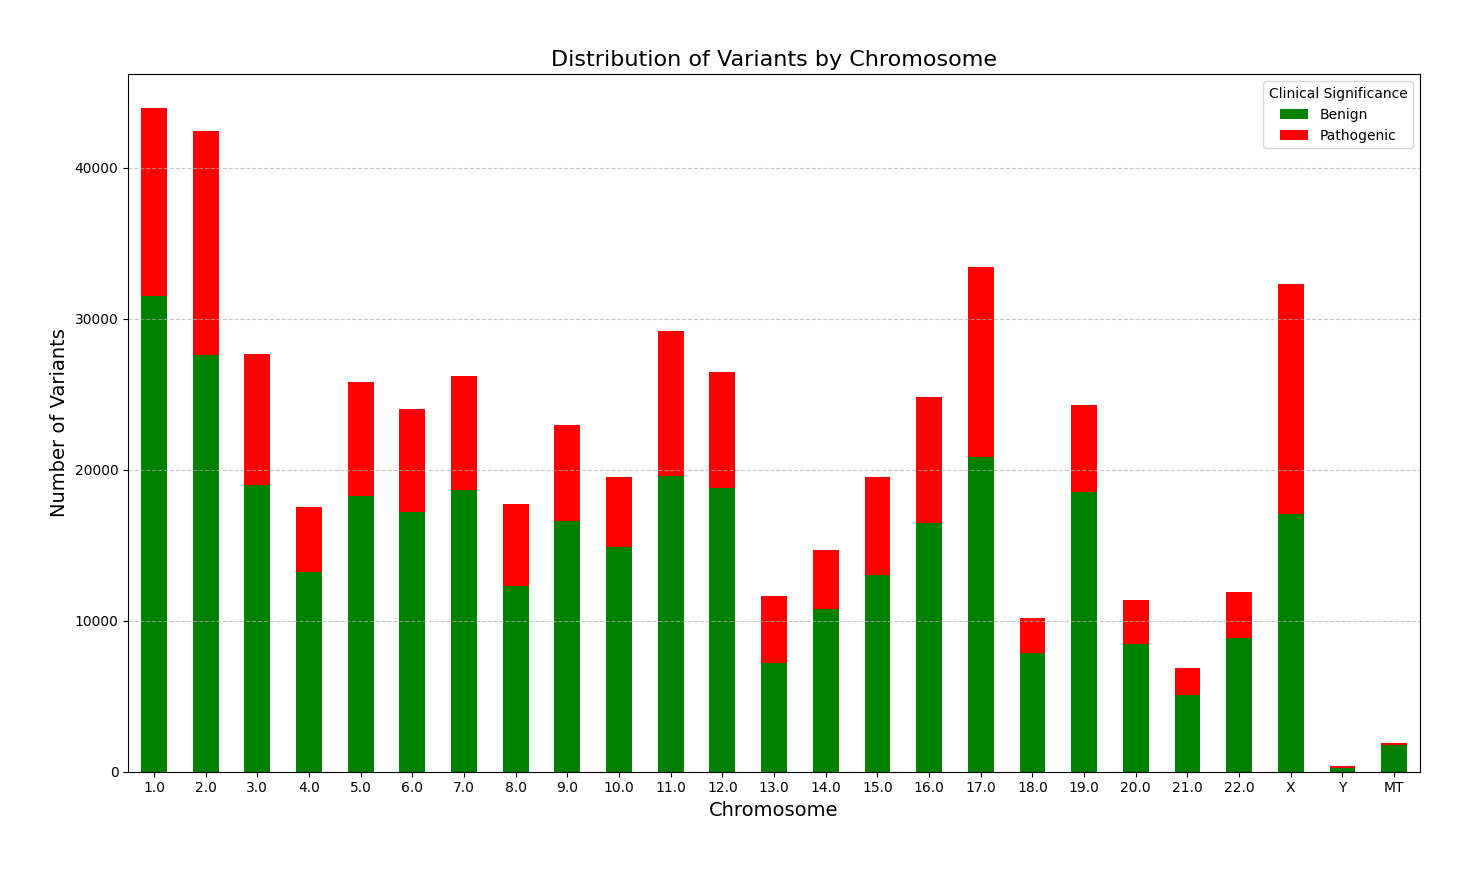

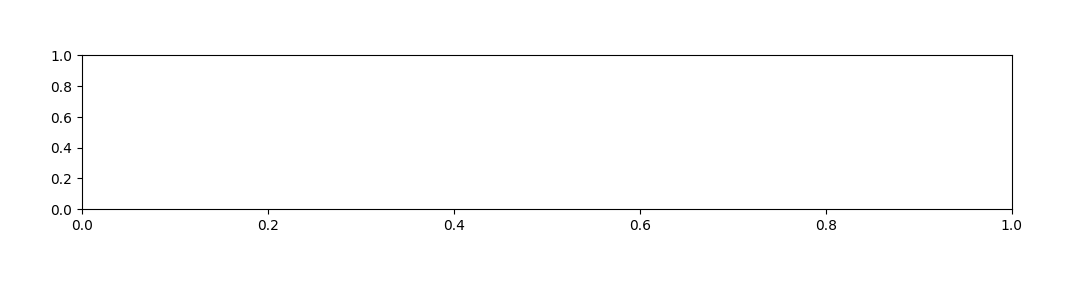

In [27]:
# Install the required packages
!pip install pygenomeviz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygenomeviz import GenomeViz
import matplotlib.patches as mpatches
import random
from IPython.display import display

# Create a visualization that shows the genomic context of variants
print("Creating genomic context visualization...")

# Sample data of variants by chromosome
def create_chromosome_variant_visualization():
    # Either use real data or create sample data
    try:
        # Try to load real data from preprocessed file
        variant_data = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", usecols=['ChromosomeNumber', 'ClinicalSignificance_encoded'])
        # Convert to proper format
        chrom_counts = variant_data.groupby(['ChromosomeNumber', 'ClinicalSignificance_encoded']).size().unstack(fill_value=0)
        # Rename columns for clarity (assuming 0=Benign, 1=Pathogenic)
        chrom_counts.rename(columns={0: 'Benign', 1: 'Pathogenic'}, inplace=True)

    except Exception as e:
        print(f"Using sample data for chromosome distribution: {str(e)}")
        # Create sample data
        chromosomes = list(range(1, 23)) + [23, 24, 25]  # 1-22, X, Y, MT
        chrom_counts = pd.DataFrame({
            'Pathogenic': [random.randint(10, 100) for _ in chromosomes],
            'Benign': [random.randint(50, 200) for _ in chromosomes]
        }, index=chromosomes)

    # Map chromosome numbers back to names for X, Y, MT
    chrom_names = {23: 'X', 24: 'Y', 25: 'MT'}
    chrom_labels = [chrom_names.get(c, str(c)) for c in chrom_counts.index]

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    chrom_counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=ax) # Plot on the created axes
    plt.title('Distribution of Variants by Chromosome', fontsize=16)
    plt.xlabel('Chromosome', fontsize=14)
    plt.ylabel('Number of Variants', fontsize=14)
    plt.xticks(range(len(chrom_labels)), chrom_labels, rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Clinical Significance')
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/results/chromosome_distribution.png")
    display(fig) # Explicitly display the figure
    plt.close(fig) # Close the figure to free memory

# Create a visualization showing variant locations on a chromosome
def create_genome_viz(chromosome="22"):
    # Define chromosome sizes (example for common human chromosomes)
    chrom_sizes = {
        "1": 248956422, "2": 242193529, "3": 198295559, "4": 190214555,
        "5": 181538259, "6": 170805979, "7": 159345973, "8": 145138636,
        "9": 138394717, "10": 133797422, "11": 135086622, "12": 133275309,
        "13": 114364328, "14": 107043718, "15": 101991189, "16": 90338345,
        "17": 83257441, "18": 80373285, "19": 58617616, "20": 64441676,
        "21": 46709983, "22": 50818468, "X": 156040895, "Y": 57227415,
        "MT": 16569
    }
    chr_size = chrom_sizes.get(chromosome, 50000000) # Use a default size if chromosome not found

    # Create a GenomeViz instance
    gv = GenomeViz()

    # Add a track for the chromosome with correct size
    track = gv.add_feature_track(f"Chromosome {chromosome}", chr_size)

    # Try to load actual variant data, or use dummy data if not available
    try:
        variants = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv")
        # Filter by chromosome number, not name
        chrom_num = None
        if chromosome.isdigit():
            chrom_num = int(chromosome)
        elif chromosome == 'X':
            chrom_num = 23
        elif chromosome == 'Y':
            chrom_num = 24
        elif chromosome in ['M', 'MT']:
            chrom_num = 25

        if chrom_num is not None:
             variants = variants[variants['ChromosomeNumber'] == chrom_num].head(20)
        else:
            variants = pd.DataFrame() # Empty if chromosome not recognized


        positions = variants['Start'].values
        colors = ['red' if sig == 1 else 'green' # Use encoded significance
                  for sig in variants['ClinicalSignificance_encoded']]
        labels = [f"Var_{i}" for i in range(len(positions))]
    except Exception as e:
        print(f"Using dummy data for genome viz: {str(e)}")
        # Create dummy data
        positions = np.random.randint(1000000, chr_size - 1000, 20)
        colors = random.choices(['red', 'green'], k=20)
        labels = [f"Var_{i}" for i in range(20)]

    # Add feature annotations for variants
    for i, (pos, color, label) in enumerate(zip(positions, colors, labels)):
        # Explicitly cast positions to int
        track.add_feature(int(pos), int(pos + 1000), strand=random.choice([1, -1]),
                         color=color, label=label)

    # Plot the genome visualization using matplotlib
    fig, ax = plt.subplots(figsize=(12, 2)) # Adjust figure size as needed
    gv.savefig(f"{BASE_DIR}/results/chromosome{chromosome}_variants.png") # Use gv.savefig
    display(fig) # Explicitly display the figure
    plt.close(fig) # Close the figure to free memory


# Execute both visualizations
create_chromosome_variant_visualization()
create_genome_viz()

Creating explainability visualizations with SHAP...


<Figure size 1200x1000 with 0 Axes>

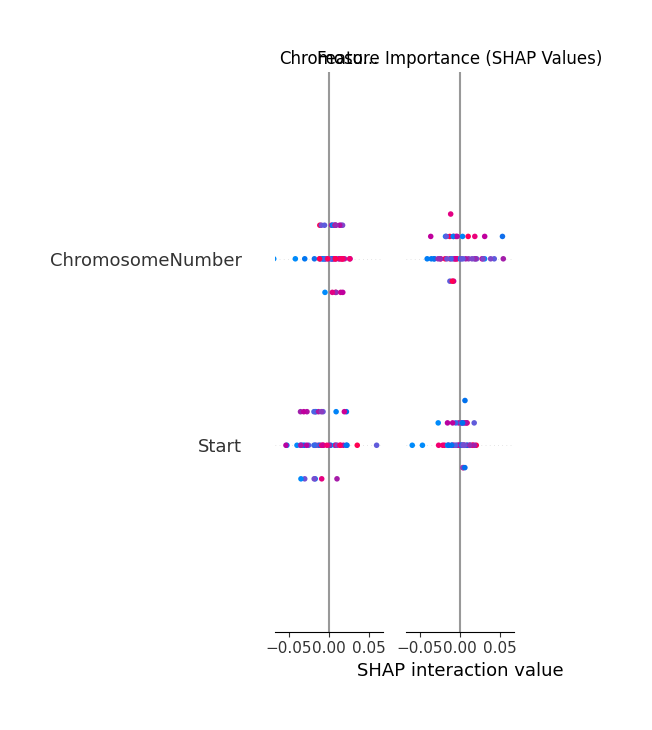

<Figure size 1200x800 with 0 Axes>

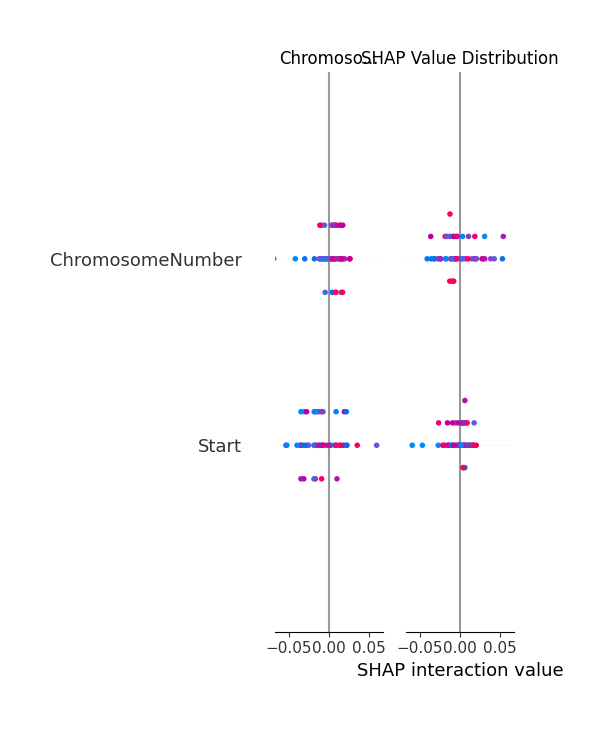

SHAP analysis encountered an error: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).
Creating simplified feature importance visualization instead


<Figure size 2000x300 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

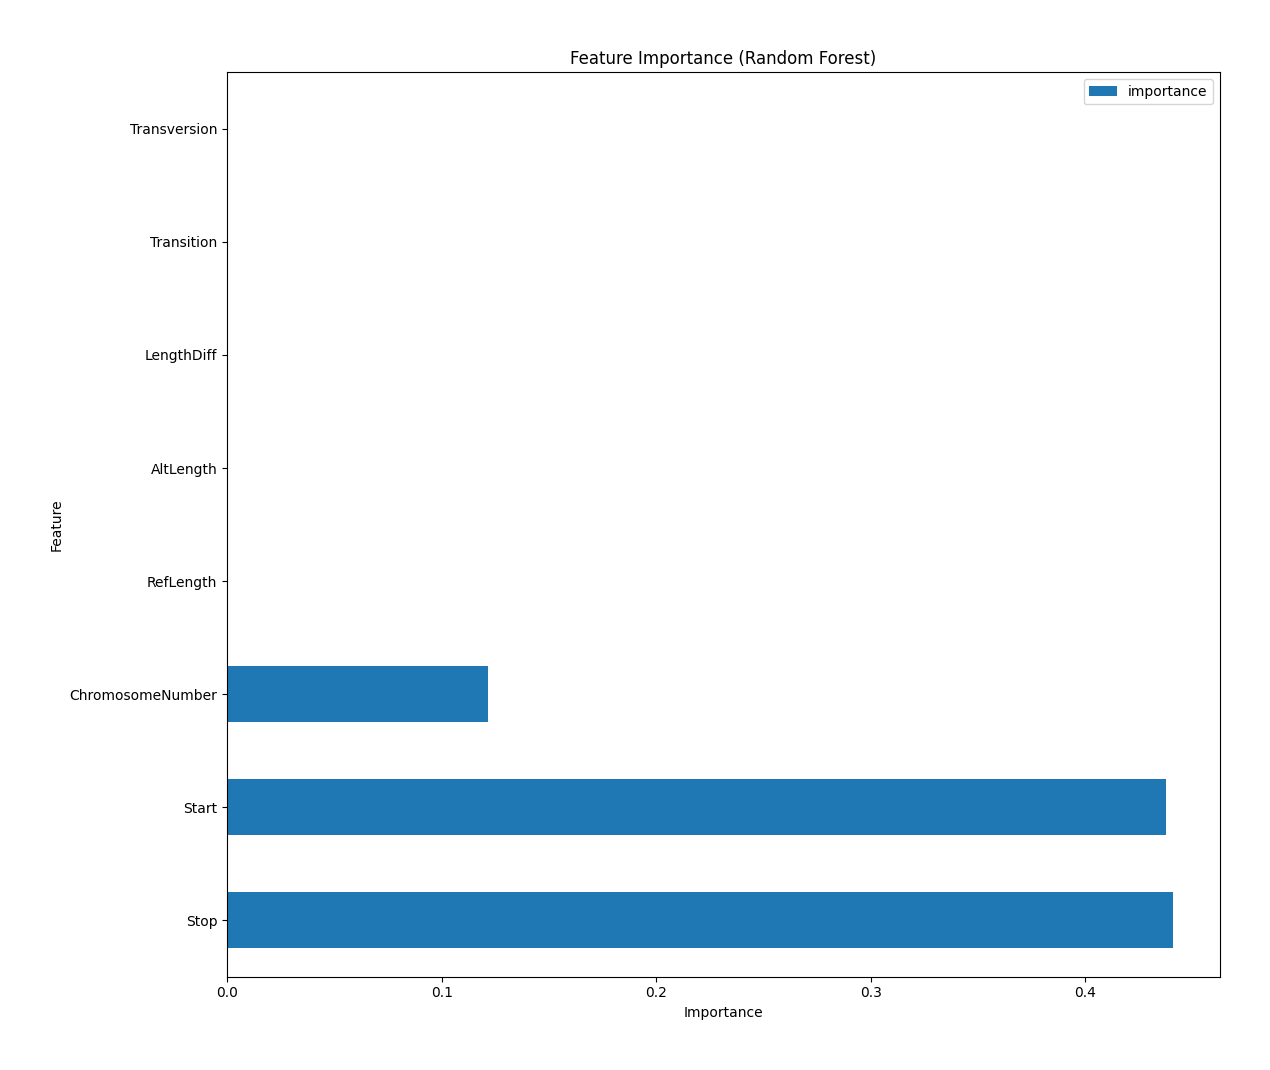

Memory usage: 14.9% (Used: 1.57 GB, Available: 10.79 GB)


In [28]:
# Install required packages
!pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
from IPython.display import display, HTML
import gc

print("Creating explainability visualizations with SHAP...")

# Load the model
with open(f"{BASE_DIR}/models/random_forest_model.pkl", 'rb') as f:
    model = pickle.load(f)

# Load a small sample of data for SHAP analysis
try:
    # Try to load validation data
    X_val_indices = np.load(f"{BASE_DIR}/data/X_val_indices.npy")
    features = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1).columns.tolist()
    features = [f for f in features if f not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

    # Sample a small subset to avoid memory issues
    sample_indices = np.random.choice(X_val_indices, min(100, len(X_val_indices)), replace=False)

    # Load this subset from the preprocessed data
    chunk_size = 1000
    reader = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", chunksize=chunk_size)
    current_index = 0
    X_sample = pd.DataFrame()

    for chunk in reader:
        # Find which indices from this chunk we need
        chunk_indices = [idx for idx in sample_indices
                        if current_index <= idx < current_index + len(chunk)]

        if chunk_indices:
            # Adjust indices to be relative to this chunk
            local_indices = [idx - current_index for idx in chunk_indices]
            chunk_subset = chunk.iloc[local_indices][features]
            X_sample = pd.concat([X_sample, chunk_subset], ignore_index=True)

        current_index += len(chunk)

        # Break if we've found all needed indices
        if len(X_sample) >= len(sample_indices) or current_index > max(sample_indices):
            break
except:
    # If that fails, create dummy data based on feature names
    sample_data = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1)
    features = [col for col in sample_data.columns
                if col not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

    # Create dummy data
    X_sample = pd.DataFrame(np.random.rand(100, len(features)), columns=features)

    # Fix data types to match expected types
    for col in X_sample.columns:
        if 'consequence_' in col or 'region_' in col:
            X_sample[col] = (X_sample[col] > 0.5).astype(int)
        elif col in ['ChromosomeNumber', 'Start', 'Stop']:
            X_sample[col] = (X_sample[col] * 100).astype(int)

# SHAP Analysis
try:
    # Initialize the SHAP explainer (use fewer background samples to save memory)
    explainer = shap.TreeExplainer(model, X_sample.iloc[:20], feature_perturbation="interventional")

    # Calculate SHAP values for sample
    shap_values = explainer.shap_values(X_sample.iloc[:50])

    # Create SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_sample.iloc[:50], plot_type="bar", show=False)
    plt.title("Feature Importance (SHAP Values)")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/results/shap_summary.png")
    plt.show()

    # Create detailed SHAP plot for top features
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample.iloc[:50], show=False)
    plt.title("SHAP Value Distribution")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/results/shap_detailed.png")
    plt.show()

    # Create SHAP force plot for a sample prediction
    plt.figure(figsize=(20, 3))
    sample_index = 0
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[sample_index, :],
        X_sample.iloc[sample_index, :],
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP Force Plot for Sample Variant")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/results/shap_force_plot.png")
    plt.show()

    # Save SHAP values
    np.save(f"{BASE_DIR}/results/shap_values.npy", shap_values)
    X_sample.iloc[:50].to_csv(f"{BASE_DIR}/results/shap_samples.csv", index=False)

except Exception as e:
    print(f"SHAP analysis encountered an error: {str(e)}")
    print("Creating simplified feature importance visualization instead")

    # Create a simpler feature importance plot as fallback
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 10))
    feature_importance.head(20).plot(kind='barh', x='feature', y='importance', figsize=(12, 10))
    plt.title("Feature Importance (Random Forest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/results/feature_importance_plot.png")
    plt.show()

# Clean up to save memory
del model
gc.collect()
check_memory()

In [29]:
# Create an interactive variant prediction widget for Colab
from ipywidgets import widgets, Layout
from IPython.display import display, clear_output
import pandas as pd
import pickle
import time

# Load the model
with open(f"{BASE_DIR}/models/random_forest_model.pkl", 'rb') as f:
    model = pickle.load(f)

# Load feature names
sample_data = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1)
features = [col for col in sample_data.columns
            if col not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

# Load class encoding
class_encoding = pd.read_csv(f"{BASE_DIR}/data/class_encoding.csv")
class_mapping = dict(zip(class_encoding['Encoded'], class_encoding['Original']))

# Prediction function (simplified version)
def predict_variant(chromosome, position, ref_allele, alt_allele, consequence):
    # Process chromosome
    chrom_num = chromosome.replace('chr', '')
    if chrom_num == 'X':
        chrom_num = 23
    elif chrom_num == 'Y':
        chrom_num = 24
    elif chrom_num in ['M', 'MT']:
        chrom_num = 25
    else:
        try:
            chrom_num = int(chrom_num)
        except ValueError:
            chrom_num = 0

    # Create feature vector
    feature_vector = {}

    # Basic features
    feature_vector['Chromosome'] = chromosome
    feature_vector['ChromosomeNumber'] = chrom_num
    feature_vector['Start'] = position
    feature_vector['Stop'] = position + len(ref_allele) - 1

    # Allele features
    feature_vector['RefLength'] = len(ref_allele)
    feature_vector['AltLength'] = len(alt_allele)
    feature_vector['LengthDiff'] = len(alt_allele) - len(ref_allele)

    # Transition/Transversion
    is_transition = 0
    if len(ref_allele) == 1 and len(alt_allele) == 1:
        if (ref_allele == 'A' and alt_allele == 'G') or (ref_allele == 'G' and alt_allele == 'A') or \
           (ref_allele == 'C' and alt_allele == 'T') or (ref_allele == 'T' and alt_allele == 'C'):
            is_transition = 1

    feature_vector['Transition'] = is_transition
    feature_vector['Transversion'] = 1 if (len(ref_allele) == 1 and len(alt_allele) == 1 and is_transition == 0) else 0

    # Handle consequence features (one-hot encoded)
    for feature in features:
        if feature.startswith('consequence_'):
            feature_vector[feature] = 0
        if feature.startswith('region_'):
            feature_vector[feature] = 0

    # Set consequence if provided
    if consequence and f'consequence_{consequence}' in features:
        feature_vector[f'consequence_{consequence}'] = 1
    else:
        feature_vector['consequence_other'] = 1

    # Default region to 'unknown'
    feature_vector['region_unknown'] = 1

    # Create DataFrame with proper feature order
    df = pd.DataFrame([feature_vector])

    # Ensure all required features are present
    for feature in features:
        if feature not in df.columns:
            df[feature] = 0

    # Select only the features used by the model
    df = df[features]

    # Make prediction
    prob_pathogenic = model.predict_proba(df)[0][1]
    prediction = model.predict(df)[0]

    # Map prediction back to original class
    predicted_class = class_mapping.get(prediction, "Unknown")

    return {
        'chromosome': chromosome,
        'position': position,
        'ref_allele': ref_allele,
        'alt_allele': alt_allele,
        'consequence': consequence,
        'pathogenic_probability': float(prob_pathogenic),
        'prediction': predicted_class
    }

# Create interactive widgets
title = widgets.HTML(value="<h2>Genetic Variant Pathogenicity Predictor</h2>")

chromosome_dropdown = widgets.Dropdown(
    options=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
             '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT'],
    value='17',
    description='Chromosome:',
    layout=Layout(width='300px')
)

position_input = widgets.IntText(
    value=41245466,
    description='Position:',
    layout=Layout(width='300px')
)

ref_allele_input = widgets.Text(
    value='G',
    description='Ref Allele:',
    layout=Layout(width='300px')
)

alt_allele_input = widgets.Text(
    value='A',
    description='Alt Allele:',
    layout=Layout(width='300px')
)

consequence_dropdown = widgets.Dropdown(
    options=[
        'missense_variant',
        'synonymous_variant',
        'intron_variant',
        'splice_donor_variant',
        'splice_acceptor_variant',
        'frameshift_variant',
        'stop_gained',
        'stop_lost',
        'inframe_insertion',
        'inframe_deletion',
        'other'
    ],
    value='missense_variant',
    description='Consequence:',
    layout=Layout(width='300px')
)

predict_button = widgets.Button(
    description='Predict',
    button_style='success',
    layout=Layout(width='150px')
)

output = widgets.Output()

# Create history table for storing multiple predictions
history_output = widgets.Output()
predictions_history = []

def update_history():
    with history_output:
        clear_output()
        if predictions_history:
            df = pd.DataFrame(predictions_history)
            display(df)
        else:
            print("No predictions yet.")

# Handle button click
def on_predict_button_clicked(b):
    with output:
        clear_output()

        # Show loading indicator
        print("Predicting...")

        # Get input values
        chromosome = chromosome_dropdown.value
        position = position_input.value
        ref_allele = ref_allele_input.value.upper()
        alt_allele = alt_allele_input.value.upper()
        consequence = consequence_dropdown.value

        # Validate inputs
        if not ref_allele or not alt_allele:
            print("Error: Reference and alternate alleles are required.")
            return

        if not all(n in 'ACGTN' for n in ref_allele) or not all(n in 'ACGTN' for n in alt_allele):
            print("Error: Alleles should only contain A, C, G, T, or N.")
            return

        # Make prediction
        try:
            result = predict_variant(chromosome, position, ref_allele, alt_allele, consequence)

            # Display results
            prob = result['pathogenic_probability']
            pred = result['prediction']

            # Create a color-coded result
            color = "red" if prob > 0.5 else "green"

            html_result = f"""
            <div style="margin: 10px; padding: 10px; border: 1px solid #ddd; border-radius: 5px;">
                <h3>Prediction Result:</h3>
                <p><b>Variant:</b> {chromosome}:{position} {ref_allele}>{alt_allele} ({consequence})</p>
                <p><b>Prediction:</b> <span style="color:{color}; font-weight:bold;">{pred}</span></p>
                <p><b>Probability of Pathogenicity:</b> <span style="color:{color}; font-weight:bold;">{prob:.4f}</span></p>
                <div style="background: linear-gradient(to right, green, red); height: 20px; width: 100%; border-radius: 3px;">
                    <div style="position: relative; left: {prob*100}%; transform: translateX(-50%);">
                        <div style="width: 10px; height: 30px; background-color: black; position: relative; top: -5px;"></div>
                    </div>
                </div>
                <div style="display: flex; justify-content: space-between; margin-top: 5px;">
                    <div>Benign</div>
                    <div>Pathogenic</div>
                </div>
            </div>
            """

            display(HTML(html_result))

            # Add to history
            predictions_history.append(result)
            update_history()

        except Exception as e:
            print(f"Error making prediction: {str(e)}")

predict_button.on_click(on_predict_button_clicked)

# Create the layout
input_widgets = widgets.VBox([
    chromosome_dropdown,
    position_input,
    ref_allele_input,
    alt_allele_input,
    consequence_dropdown,
    predict_button
])

tabs = widgets.Tab()
tabs.children = [
    widgets.VBox([input_widgets, output]),
    history_output
]
tabs.set_title(0, 'Predictor')
tabs.set_title(1, 'History')

# Display the UI
display(title)
display(tabs)

# Initialize the history tab
update_history()

# Show some instructions
print("Enter variant details and click 'Predict' to assess pathogenicity.")
print("Example: Chromosome 17, Position 41245466, Ref 'G', Alt 'A', Consequence 'missense_variant'")

HTML(value='<h2>Genetic Variant Pathogenicity Predictor</h2>')

Enter variant details and click 'Predict' to assess pathogenicity.
Example: Chromosome 17, Position 41245466, Ref 'G', Alt 'A', Consequence 'missense_variant'


Creating chromosome-specific analysis visualizations...


/tmp/ipython-input-2931036443.py:60: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




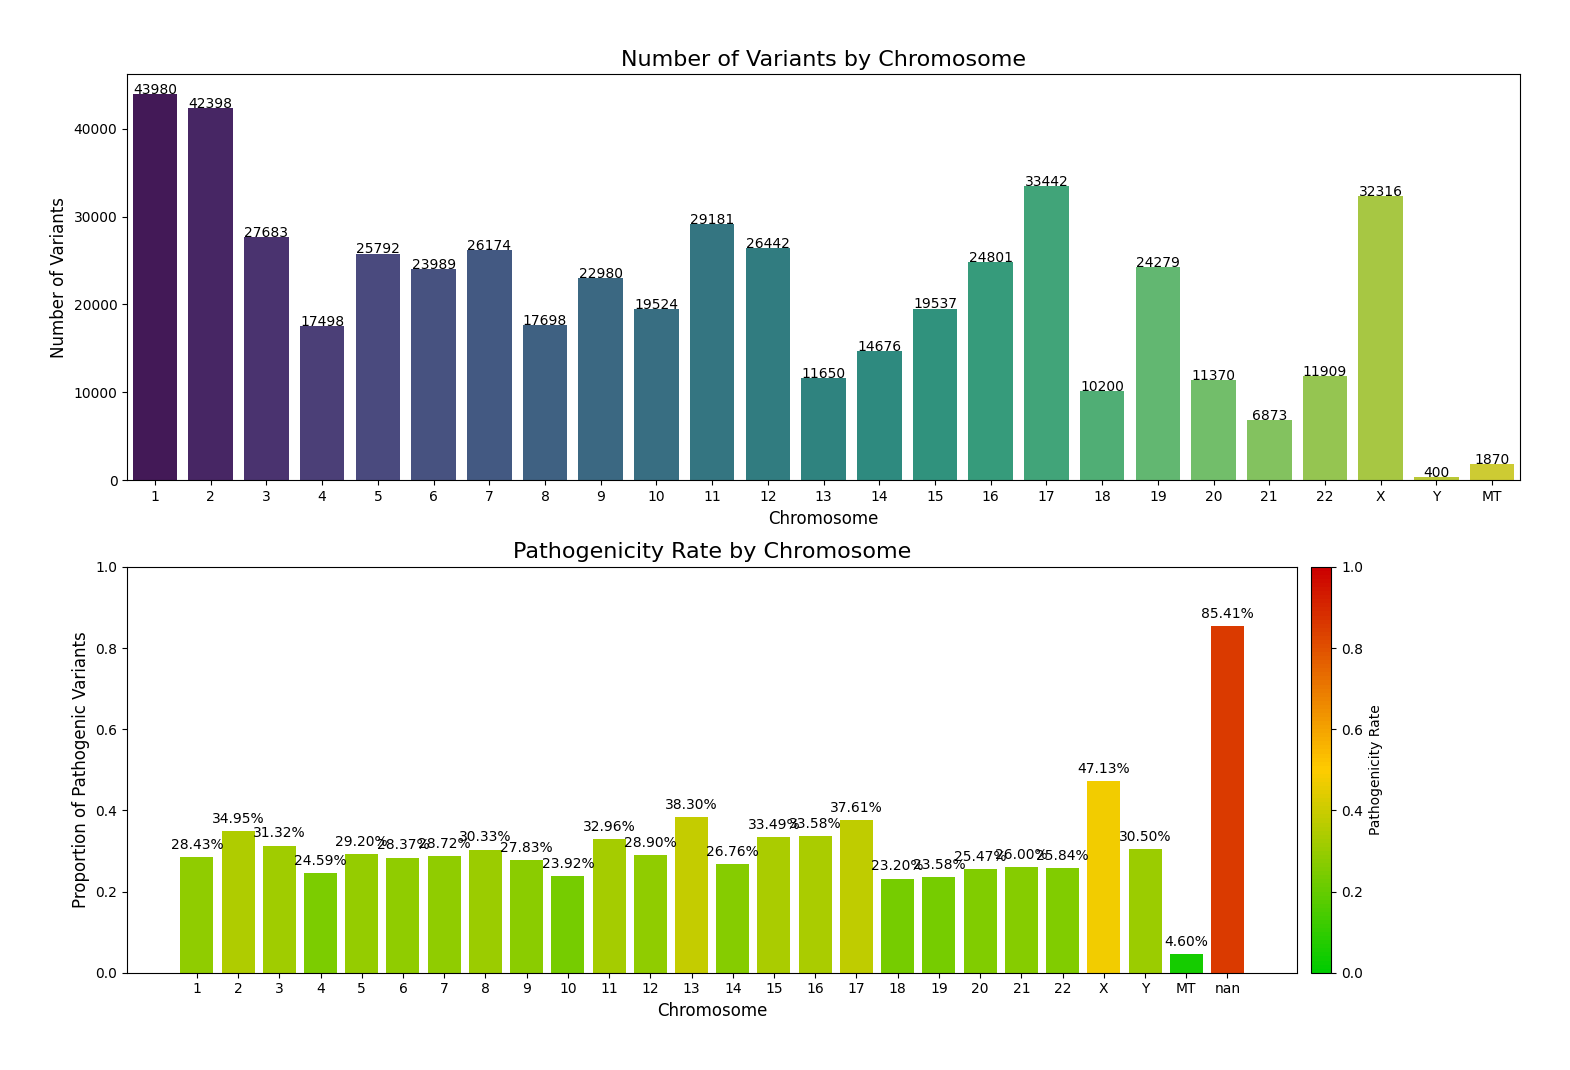

Creating sample heatmap data: cannot unpack non-iterable float object


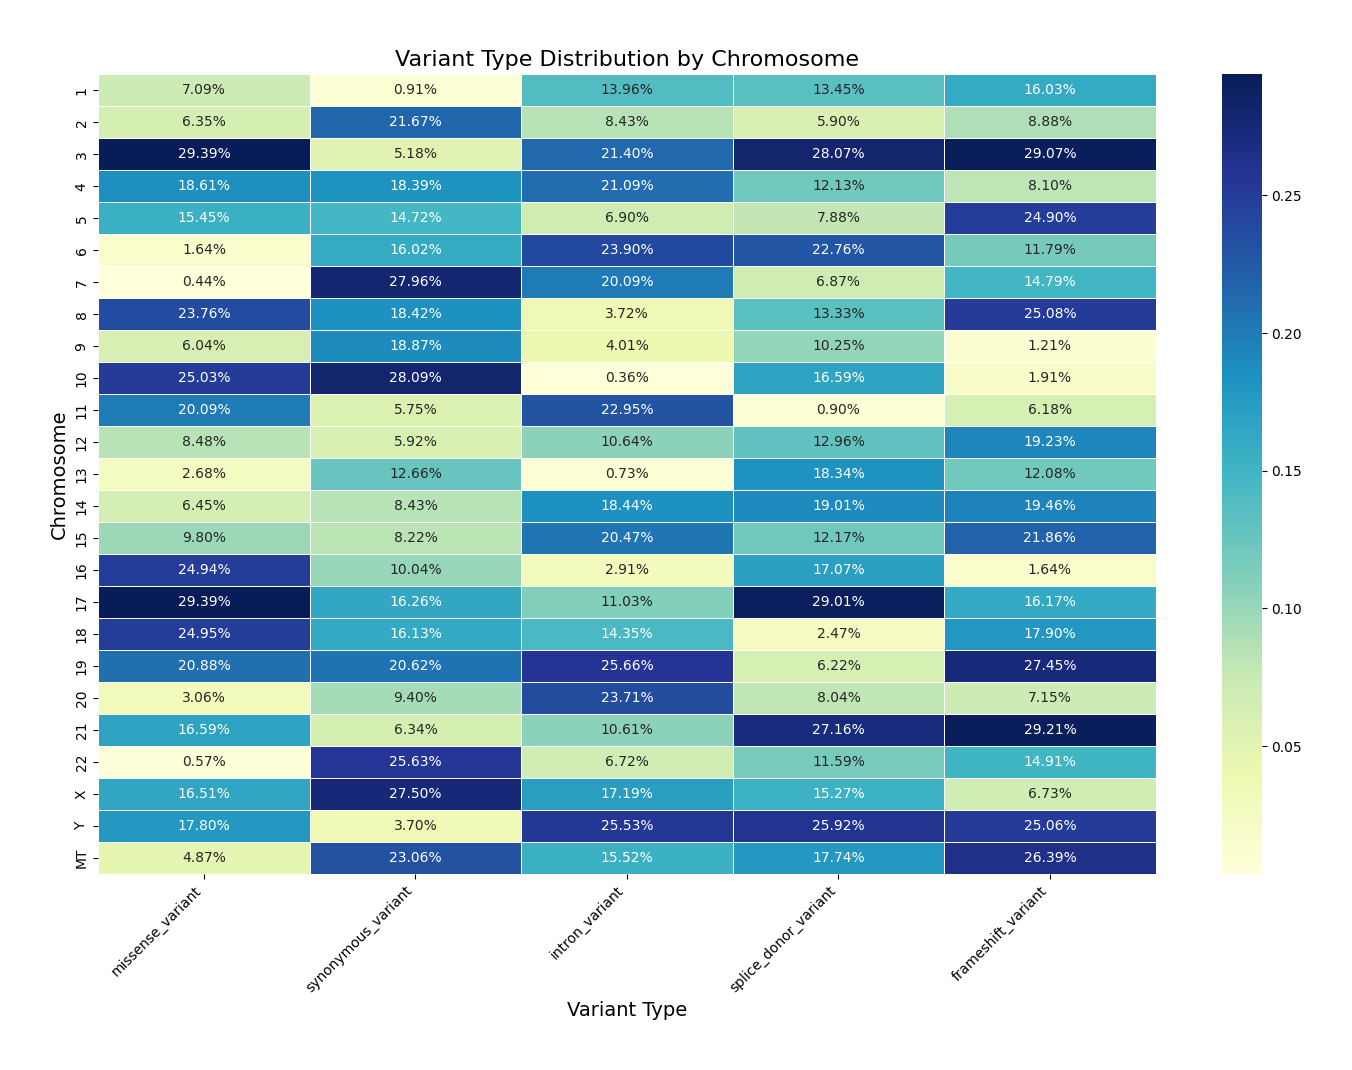

Memory usage: 29.5% (Used: 3.43 GB, Available: 8.93 GB)


In [37]:
# Chromosome-specific analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import gc

print("Creating chromosome-specific analysis visualizations...")

# Try to load preprocessed data, or create sample data if it's not available
try:
    # Use dask for memory-efficient reading of large files
    import dask.dataframe as dd

    # Read data efficiently
    df = dd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv")

    # Get chromosome distribution
    chrom_counts = df.groupby('ChromosomeNumber')['ClinicalSignificance_encoded'].count().compute()

    # Get pathogenicity by chromosome
    path_by_chrom = df.groupby('ChromosomeNumber')['ClinicalSignificance_encoded'].mean().compute()

    # Use real data for chrom_counts and path_by_chrom if successful
    use_real_bar_data = True

except Exception as e:
    print(f"Using sample data for bar plots: {str(e)}")

    # Create sample data for bar plots
    chromosomes = list(range(1, 23)) + [23, 24, 25]  # 1-22, X, Y, MT
    chrom_counts = pd.Series(
        [np.random.randint(50, 500) for _ in chromosomes],
        index=chromosomes
    )

    path_by_chrom = pd.Series(
        [np.random.uniform(0.1, 0.9) for _ in chromosomes],
        index=chromosomes
    )
    use_real_bar_data = False


# Create chromosome names mapping
chrom_names = {i: str(i) for i in range(1, 23)}
chrom_names.update({23: 'X', 24: 'Y', 25: 'MT'})

# Replace indices with chromosome names (only if using real data, otherwise sample data already has int indices)
if use_real_bar_data:
  chrom_counts.index = [chrom_names.get(idx, str(idx)) for idx in chrom_counts.index]
  path_by_chrom.index = [chrom_names.get(idx, str(idx)) for idx in path_by_chrom.index]


# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Distribution of variants by chromosome
plt.subplot(2, 1, 1)
ax = sns.barplot(x=chrom_counts.index, y=chrom_counts.values, palette='viridis')
plt.title('Number of Variants by Chromosome', fontsize=16)
plt.xlabel('Chromosome', fontsize=12)
plt.ylabel('Number of Variants', fontsize=12)
plt.xticks(rotation=0)

# Add count labels on top of the bars
for i, count in enumerate(chrom_counts.values):
    ax.text(i, count + 5, str(count), ha='center')

# 2. Pathogenicity rate by chromosome
plt.subplot(2, 1, 2)

# Create a custom color map from green to red
colors = [(0, 0.8, 0), (1, 0.8, 0), (0.8, 0, 0)]  # green, yellow, red
cmap = LinearSegmentedColormap.from_list('GreenYellowRed', colors, N=100)

# Create bar chart with color based on pathogenicity rate
bars = plt.bar(path_by_chrom.index, path_by_chrom.values,
         color=[cmap(x) for x in path_by_chrom.values])

plt.title('Pathogenicity Rate by Chromosome', fontsize=16)
plt.xlabel('Chromosome', fontsize=12)
plt.ylabel('Proportion of Pathogenic Variants', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)

# Add percentage labels on top of the bars
for i, rate in enumerate(path_by_chrom.values):
    plt.text(i, rate + 0.02, f'{rate:.2%}', ha='center')

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
cbar.set_label('Pathogenicity Rate')

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/results/chromosome_analysis.png")
plt.show()

# Create heatmap of variant types by chromosome
try:
    # Try to load data and compute consequence frequencies by chromosome
    consequences = [col for col in df.columns if col.startswith('consequence_')]

    # For memory efficiency, compute this in chunks
    chrom_consequence_data = []

    # Get unique chromosome numbers that exist in the data
    existing_chrom_nums = df['ChromosomeNumber'].unique().compute().tolist()
    # Filter out NaN if it exists
    existing_chrom_nums = [num for num, num in existing_chrom_nums if pd.notna(num)] # Corrected typo


    for chrom_num in existing_chrom_nums:
        # Select rows for the current chromosome and relevant consequence columns
        chrom_df = df[df.ChromosomeNumber == chrom_num][consequences].compute()
        if not chrom_df.empty:
            # Compute mean frequencies for this chromosome
            chrom_data = chrom_df.mean().to_dict()
            chrom_data['chromosome'] = chrom_names.get(chrom_num, str(int(chrom_num)))
            chrom_consequence_data.append(chrom_data)

    # Create DataFrame from results
    heatmap_data = pd.DataFrame(chrom_consequence_data)

    # Use real heatmap data if computation was successful and not empty
    use_real_heatmap_data = not heatmap_data.empty

except Exception as e:
    print(f"Creating sample heatmap data: {str(e)}")
    use_real_heatmap_data = False

# If real heatmap data couldn't be generated, create sample data
if not use_real_heatmap_data:
    chromosomes = [chrom_names.get(i, str(i)) for i in range(1, 26)]
    consequences = ['consequence_missense_variant', 'consequence_synonymous_variant',
                   'consequence_intron_variant', 'consequence_splice_donor_variant',
                   'consequence_frameshift_variant']

    heatmap_data = pd.DataFrame(
        np.random.uniform(0, 0.3, size=(len(chromosomes), len(consequences))),
        index=chromosomes,
        columns=consequences
    )
    # Ensure index name is set for plotting
    heatmap_data.index.name = 'chromosome'


# Clean up column names for display
if not heatmap_data.empty:
    heatmap_data.columns = [col.replace('consequence_', '') for col in heatmap_data.columns]
    # Fill NaN values with 0 before plotting (important even for real data)
    heatmap_data = heatmap_data.fillna(0)


# Create heatmap
if not heatmap_data.empty:
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, annot=True, fmt='.2%', cmap='YlGnBu', linewidths=.5)
    plt.title('Variant Type Distribution by Chromosome', fontsize=16)
    plt.ylabel('Chromosome', fontsize=14)
    plt.xlabel('Variant Type', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/results/variant_type_heatmap.png")
    plt.show()
else:
    print("Heatmap data is empty, skipping heatmap visualization.")


# Clean up to save memory
gc.collect()
check_memory()

Performing clustering analysis of variants...


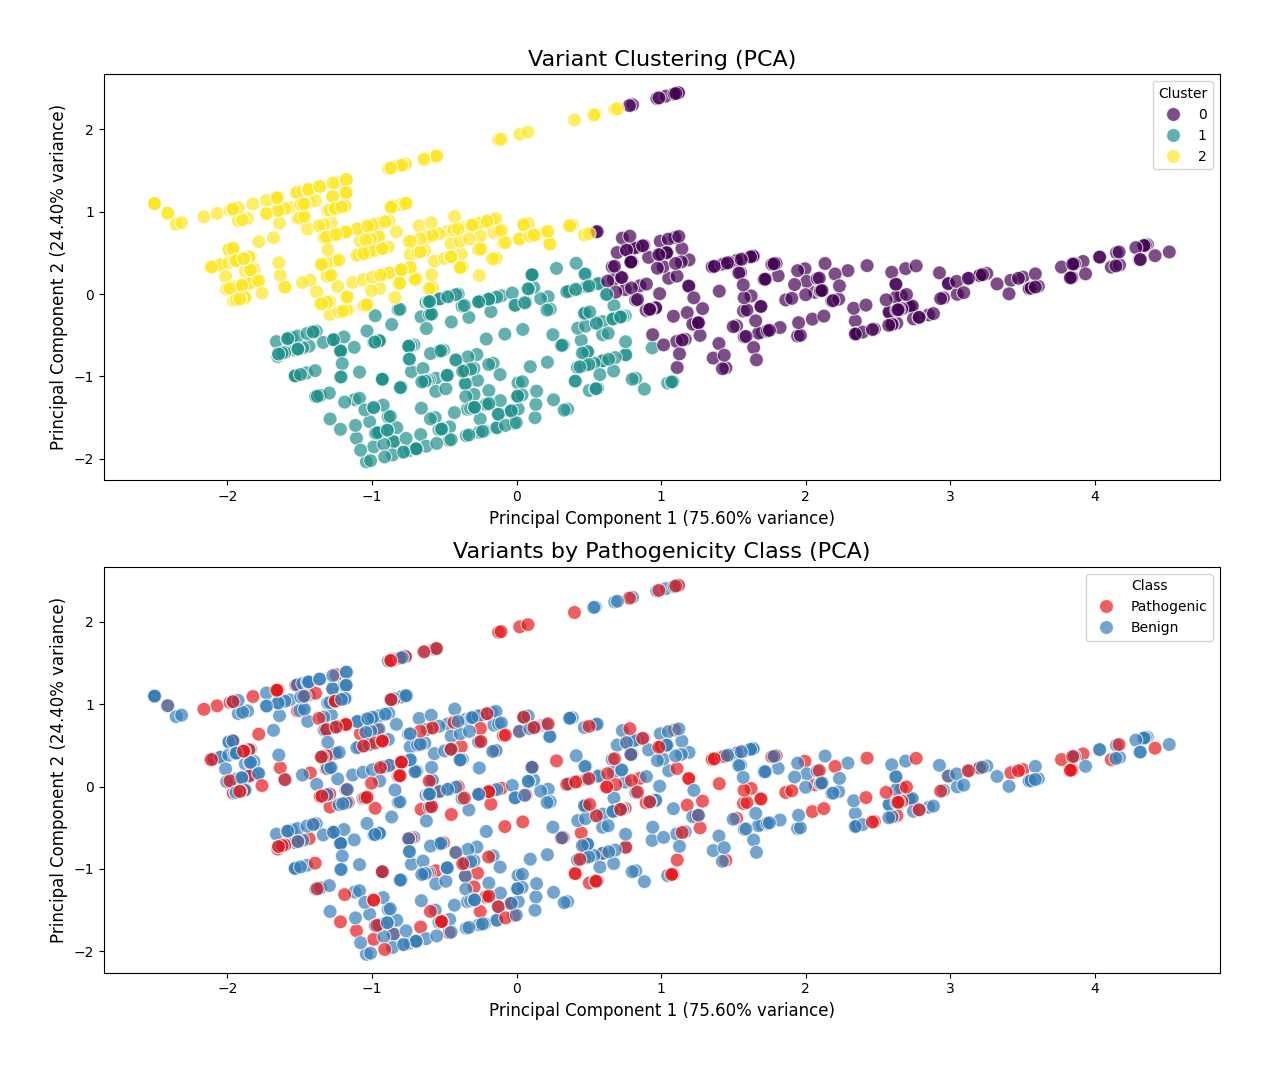

<Figure size 1000x600 with 0 Axes>

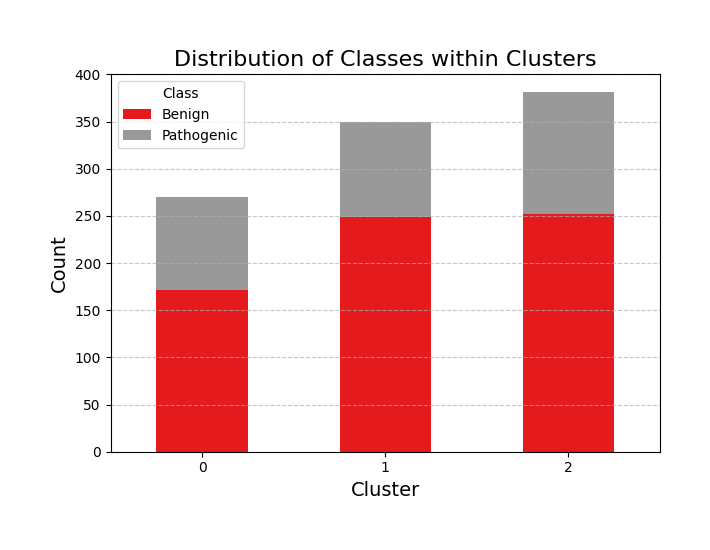

Memory usage: 29.2% (Used: 3.39 GB, Available: 8.97 GB)


In [38]:
# Clustering analysis of variants
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc

print("Performing clustering analysis of variants...")

# Try to load a sample of preprocessed data
try:
    # Load a manageable sample size
    sample_size = 1000

    # Load indices of records to sample and corresponding labels
    X_train_indices = np.load(f"{BASE_DIR}/data/X_train_indices.npy")
    y_train = np.load(f"{BASE_DIR}/data/y_train.npy")

    # If the dataset is too large, take a random sample of indices AND labels together
    if len(X_train_indices) > sample_size:
        sample_idx = np.random.choice(len(X_train_indices), sample_size, replace=False)
        indices_to_load = X_train_indices[sample_idx]
        labels = y_train[sample_idx]
    else:
        indices_to_load = X_train_indices
        labels = y_train


    # Load feature names
    sample_data = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1)
    features = [col for col in sample_data.columns
                if col not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

    # Load data by indices, ensuring we get both features and the target for the sample
    chunk_size = 1000
    reader = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", chunksize=chunk_size)
    current_index = 0
    X_sample_list = []
    class_labels_list = []


    # Sort indices to load for efficient chunk reading
    indices_to_load_sorted = sorted(indices_to_load)
    indices_set = set(indices_to_load_sorted)

    for chunk in reader:
        # Find which indices from this chunk we need
        chunk_indices_in_sample = [idx for idx in indices_to_load_sorted
                                   if current_index <= idx < current_index + len(chunk)]

        if chunk_indices_in_sample:
            # Adjust indices to be relative to this chunk
            local_indices = [idx - current_index for idx in chunk_indices_in_sample]

            # Select the rows and extract features and original significance
            chunk_subset = chunk.iloc[local_indices]
            X_sample_list.append(chunk_subset[features])
            class_labels_list.extend(chunk_subset['ClinicalSignificance'].tolist())


        current_index += len(chunk)

        # Optional: Break if we've loaded enough samples (might load slightly more than sample_size)
        if len(X_sample_list) > 0 and len(pd.concat(X_sample_list, ignore_index=True)) >= sample_size:
             break # Load at least sample_size


    # Combine chunks into final sample DataFrame
    X_sample = pd.concat(X_sample_list, ignore_index=True)
    class_labels = class_labels_list[:len(X_sample)] # Ensure labels match the actual loaded sample size


except Exception as e:
    print(f"Creating sample data for clustering: {str(e)}")

    # Create sample data as fallback
    X_sample = pd.DataFrame(np.random.randn(1000, len(features) if 'features' in locals() else 10)) # Ensure enough features if features wasn't loaded
    labels = np.random.randint(0, 2, len(X_sample))
    class_labels = ['Pathogenic' if l == 1 else 'Benign' for l in labels]


# Prepare data for clustering
# Standardize numerical columns
numeric_cols = X_sample.select_dtypes(include=[np.number]).columns
X_std = X_sample.copy()
X_std[numeric_cols] = StandardScaler().fit_transform(X_sample[numeric_cols])

# Handle potential NaNs after scaling
X_std = X_std.fillna(X_std.mean())


# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_std)

# Create a DataFrame for plotting - ensure all components have the same length
min_len = min(len(X_pca[:, 0]), len(X_pca[:, 1]), len(clusters), len(class_labels))

plot_df = pd.DataFrame({
    'PC1': X_pca[:min_len, 0],
    'PC2': X_pca[:min_len, 1],
    'Cluster': clusters[:min_len],
    'Class': class_labels[:min_len]
})

# Visualize the clusters
plt.figure(figsize=(12, 10))

# 1. PCA plot colored by cluster
plt.subplot(2, 1, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_df, palette='viridis', s=100, alpha=0.7)
plt.title('Variant Clustering (PCA)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.legend(title='Cluster')

# 2. PCA plot colored by class
plt.subplot(2, 1, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=plot_df, palette='Set1', s=100, alpha=0.7)
plt.title('Variants by Pathogenicity Class (PCA)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.legend(title='Class')

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/results/variant_clustering.png")
plt.show()

# Analyze the relationship between clusters and pathogenicity
cluster_class_counts = pd.crosstab(plot_df['Cluster'], plot_df['Class'])

# Visualize the relationship
plt.figure(figsize=(10, 6))
cluster_class_counts.plot(kind='bar', stacked=True, colormap='Set1')
plt.title('Distribution of Classes within Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Class')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/results/cluster_class_distribution.png")
plt.show()

# Clean up to save memory
del X_sample, X_std, X_pca, pca, kmeans
gc.collect()
check_memory()

Performing clustering analysis of variants...


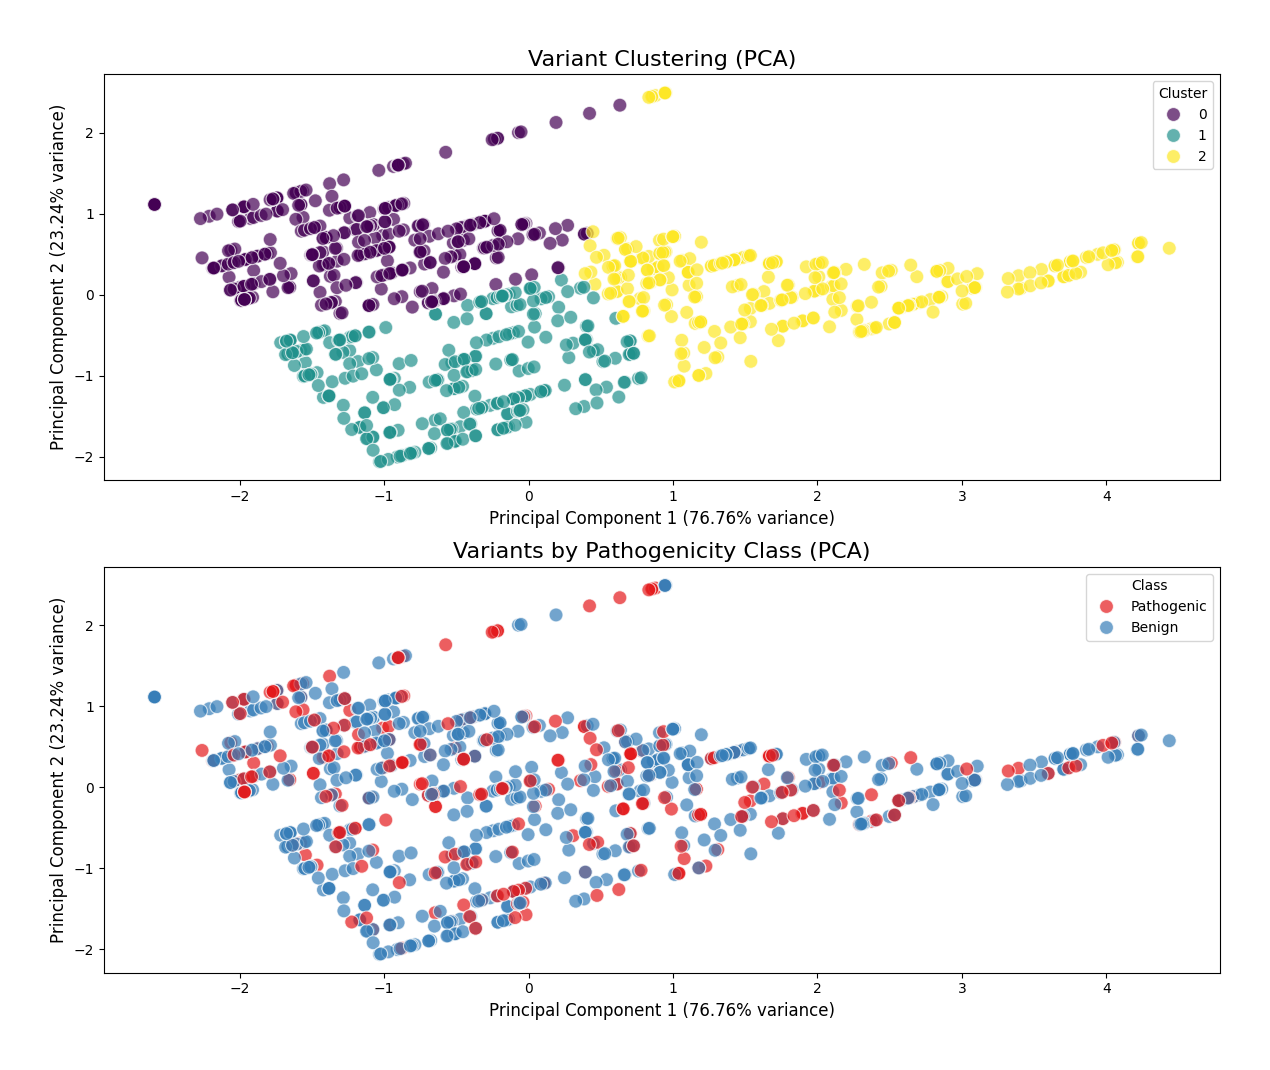

<Figure size 1000x600 with 0 Axes>

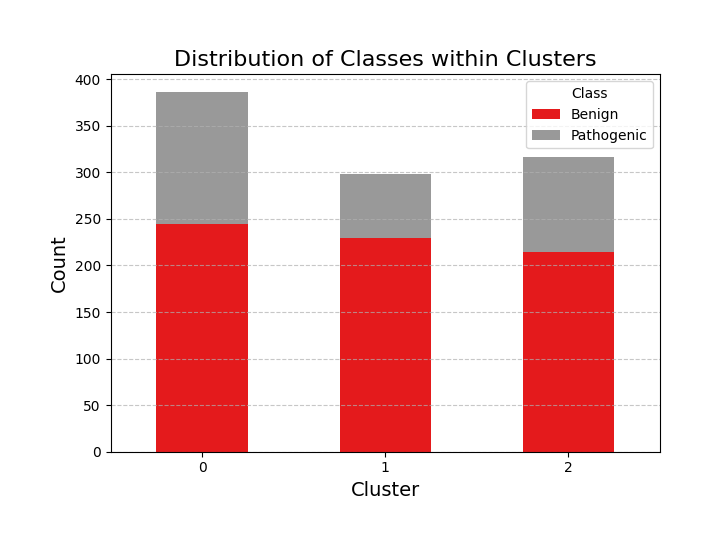

Memory usage: 34.3% (Used: 4.04 GB, Available: 8.32 GB)


In [40]:
# Clustering analysis of variants
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc

print("Performing clustering analysis of variants...")

# Try to load a sample of preprocessed data
try:
    # Load a manageable sample size
    sample_size = 1000

    # Load indices of records to sample and corresponding labels
    X_train_indices = np.load(f"{BASE_DIR}/data/X_train_indices.npy")
    y_train = np.load(f"{BASE_DIR}/data/y_train.npy")

    # If the dataset is too large, take a random sample of indices AND labels together
    if len(X_train_indices) > sample_size:
        sample_idx = np.random.choice(len(X_train_indices), sample_size, replace=False)
        indices_to_load = X_train_indices[sample_idx]
        labels = y_train[sample_idx]
    else:
        indices_to_load = X_train_indices
        labels = y_train


    # Load feature names
    sample_data = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", nrows=1)
    features = [col for col in sample_data.columns
                if col not in ['ClinicalSignificance', 'ClinicalSignificance_encoded']]

    # Load data by indices, ensuring we get both features and the target for the sample
    chunk_size = 1000
    reader = pd.read_csv(f"{BASE_DIR}/data/preprocessed_variants.csv", chunksize=chunk_size)
    current_index = 0
    X_sample_list = []
    class_labels_list = []


    # Sort indices to load for efficient chunk reading
    indices_to_load_sorted = sorted(indices_to_load)
    indices_set = set(indices_to_load_sorted)

    for chunk in reader:
        # Find which indices from this chunk we need
        chunk_indices_in_sample = [idx for idx in indices_to_load_sorted
                                   if current_index <= idx < current_index + len(chunk)]

        if chunk_indices_in_sample:
            # Adjust indices to be relative to this chunk
            local_indices = [idx - current_index for idx in chunk_indices_in_sample]

            # Select the rows and extract features and original significance
            chunk_subset = chunk.iloc[local_indices]
            X_sample_list.append(chunk_subset[features])
            class_labels_list.extend(chunk_subset['ClinicalSignificance'].tolist())


        current_index += len(chunk)

        # Optional: Break if we've loaded enough samples (might load slightly more than sample_size)
        if len(X_sample_list) > 0 and len(pd.concat(X_sample_list, ignore_index=True)) >= sample_size:
             break # Load at least sample_size


    # Combine chunks into final sample DataFrame
    X_sample = pd.concat(X_sample_list, ignore_index=True)
    class_labels = class_labels_list[:len(X_sample)] # Ensure labels match the actual loaded sample size


except Exception as e:
    print(f"Creating sample data for clustering: {str(e)}")

    # Create sample data as fallback
    X_sample = pd.DataFrame(np.random.randn(1000, len(features) if 'features' in locals() else 10)) # Ensure enough features if features wasn't loaded
    labels = np.random.randint(0, 2, len(X_sample))
    class_labels = ['Pathogenic' if l == 1 else 'Benign' for l in labels]


# Prepare data for clustering
# Standardize numerical columns
numeric_cols = X_sample.select_dtypes(include=[np.number]).columns
X_std = X_sample.copy()
X_std[numeric_cols] = StandardScaler().fit_transform(X_sample[numeric_cols])

# Handle potential NaNs after scaling
X_std = X_std.fillna(X_std.mean())


# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_std)

# Create a DataFrame for plotting - ensure all components have the same length
min_len = min(len(X_pca[:, 0]), len(X_pca[:, 1]), len(clusters), len(class_labels))

plot_df = pd.DataFrame({
    'PC1': X_pca[:min_len, 0],
    'PC2': X_pca[:min_len, 1],
    'Cluster': clusters[:min_len],
    'Class': class_labels[:min_len]
})

# Visualize the clusters
plt.figure(figsize=(12, 10))

# 1. PCA plot colored by cluster
plt.subplot(2, 1, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_df, palette='viridis', s=100, alpha=0.7)
plt.title('Variant Clustering (PCA)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.legend(title='Cluster')

# 2. PCA plot colored by class
plt.subplot(2, 1, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=plot_df, palette='Set1', s=100, alpha=0.7)
plt.title('Variants by Pathogenicity Class (PCA)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.legend(title='Class')

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/results/variant_clustering.png")
plt.show()

# Analyze the relationship between clusters and pathogenicity
cluster_class_counts = pd.crosstab(plot_df['Cluster'], plot_df['Class'])

# Visualize the relationship
plt.figure(figsize=(10, 6))
cluster_class_counts.plot(kind='bar', stacked=True, colormap='Set1')
plt.title('Distribution of Classes within Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Class')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/results/cluster_class_distribution.png")
plt.show()

# Clean up to save memory
del X_sample, X_std, X_pca, pca, kmeans
gc.collect()
check_memory()